+ Write anything you need to test

In [1]:
import pandas as pd
import numpy as np
import pickle

from tqdm import tqdm

from tools import Train, validation, GridSearch

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import r2_score, mean_absolute_error

In [3]:
with open('data/train_dataset_masked.pickle', 'rb') as f:
    train_dataset = pickle.load(f)

with open('data/val_dataset_masked.pickle', 'rb') as f:
    val_dataset = pickle.load(f)

with open('data/test_dataset_masked.pickle', 'rb') as f:
    test_dataset = pickle.load(f)

In [4]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [6]:
criterion = nn.MSELoss()
eval_metrics = [
    r2_score,
    mean_absolute_error
]

In [7]:
class SimpleLSTM(nn.Module):
    def __init__(self, n, m, num_layers):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=n, hidden_size=m, num_layers=num_layers, batch_first=False)
        self.linear_output = nn.Sequential(
            nn.Linear(m, 2*m),
            nn.ReLU(),
            nn.Linear(2*m, 1)
        )
    

    def forward(self, X): # (-1 x T x n)
        X = X.permute(1, 0, 2) # (T x -1 x n)
        output, _ = self.lstm(X) # (T x -1 x m), ((`num_layers` x -1 x m), (`num_layers` x -1 x m))
        output = output[-1] # (-1 x m)
        output = self.linear_output(output).squeeze(dim=1) # (-1 x 1) -> (-1)

        return output

In [8]:
basic_params = {
    'n': 40
}

param_grid = {
    'm': [128, 32, 40],
    'num_layers': [1, 2, 3]
}

model_name = 'Simple_LSTM'
grid_model = GridSearch(criterion, eval_metrics, device, temp_save_path=f'checkpoints/model_by_param/temp_{model_name}.pt', masked=False)
best_model = grid_model.train_by_grid(
        SimpleLSTM, basic_params, param_grid,
        torch.optim.Adam, train_loader, val_loader,
        patience=3, epochs=20,
        save_filename=f'checkpoints/{model_name}_best.pt'
    )

Total   9 cases are going to be searched.
Setting   0 of Parameters Grid is now on progres.


Epoch 13: 100%|██████████| 1304/1304 [00:03<00:00, 413.30it/s, Train Loss=0.3769, Valid Loss=0.4607, Valid R2=-0.0396, Valid MAE=0.5488]


Early Stopped
Setting   1 of Parameters Grid is now on progres.


Epoch  7: 100%|██████████| 1304/1304 [00:03<00:00, 344.32it/s, Train Loss=0.0859, Valid Loss=0.5957, Valid R2=-0.3442, Valid MAE=0.5992]


Early Stopped
Setting   2 of Parameters Grid is now on progres.


Epoch  5: 100%|██████████| 1304/1304 [00:04<00:00, 275.89it/s, Train Loss=0.1176, Valid Loss=0.4195, Valid R2=0.0535, Valid MAE=0.5384]


Early Stopped
Setting   3 of Parameters Grid is now on progres.


Epoch  9: 100%|██████████| 1304/1304 [00:03<00:00, 385.62it/s, Train Loss=0.9573, Valid Loss=1.4133, Valid R2=-2.1889, Valid MAE=0.8737]


Early Stopped
Setting   4 of Parameters Grid is now on progres.


Epoch 16: 100%|██████████| 1304/1304 [00:03<00:00, 339.38it/s, Train Loss=0.3193, Valid Loss=0.8553, Valid R2=-0.9298, Valid MAE=0.6611]


Early Stopped
Setting   5 of Parameters Grid is now on progres.


Epoch 10: 100%|██████████| 1304/1304 [00:04<00:00, 287.86it/s, Train Loss=0.4305, Valid Loss=0.9020, Valid R2=-1.0352, Valid MAE=0.6687]


Early Stopped
Setting   6 of Parameters Grid is now on progres.


Epoch 10: 100%|██████████| 1304/1304 [00:03<00:00, 384.86it/s, Train Loss=0.7774, Valid Loss=0.6832, Valid R2=-0.5416, Valid MAE=0.5683]


Early Stopped
Setting   7 of Parameters Grid is now on progres.


Epoch 19: 100%|██████████| 1304/1304 [00:03<00:00, 331.24it/s, Train Loss=0.1484, Valid Loss=0.2972, Valid R2=0.3295, Valid MAE=0.4391]


Setting   8 of Parameters Grid is now on progres.


Epoch 12: 100%|██████████| 1304/1304 [00:04<00:00, 283.02it/s, Train Loss=0.2219, Valid Loss=0.4469, Valid R2=-0.0084, Valid MAE=0.5290]


Early Stopped


Test Loss: 0.3700 | Test R2: 0.7991 | Test MAE: 0.4861
Saving Process Complete. Directory: Simple_LSTM_losses.png


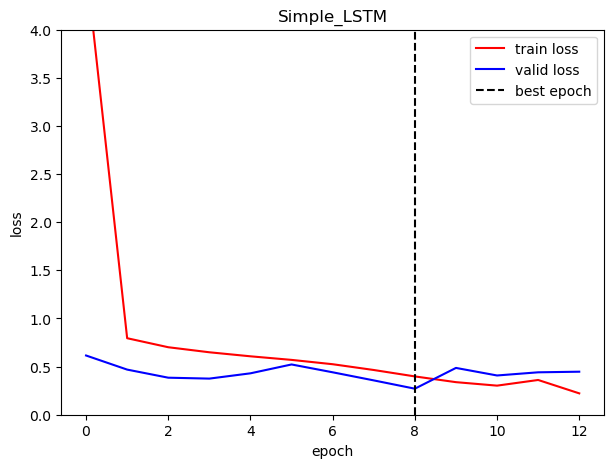

In [9]:
grid_model.test(test_loader)
grid_model.plot_losses(plot_title=f'{model_name}', save_filename=f'{model_name}_losses.png')